## Information Retrieval

In [1]:
file_base = "./data"

In [2]:
import os

In [3]:
len(os.listdir(file_base))

971

## Task, build a search engine, input: some words, output are the documents.

In [4]:
import jieba

In [5]:
def cut(string): return " ".join(jieba.cut(string))

In [6]:
corpus = [
    cut(open(os.path.join(file_base, f)).read()) for f in os.listdir(file_base)
]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_8/f14fxxnn7w13cd0l5x9hl4bm0000gn/T/jieba.cache
Loading model cost 0.883 seconds.
Prefix dict has been built succesfully.


In [7]:
corpus[:10]

['。 通常 在 这 上面 会 印上 文字 与 符号 （ 大多 是 白色 的 , 在 Top   Overlay   和 Bottom   Overlay',
 '辅助 编辑 原因 ： 文章 标题 略有 误导 ， 辅助 修改 标题 。 原 标题   “ ALTIUM _ DESIGNER _ 10 新 功能 试用 ”                 另 文章 为 早期 转载 文章 ， 故对 原 文章 标题 不 做 纠正 ... 再次 感谢 网友 推荐 文章 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *',
 '谢谢你们 发 的 好东东',
 'wypcb   发表 于   2014 - 6 - 5   22 : 09a2763338   发表 于   2014 - 12 - 22   11 : 20',
 '层次化 原理图 电气 检查 时 出现 . SchDoc         Compiler         Duplicate   Net   Names   Element [ - 1 ] 网上 查 了   说 什么 放置   网络 标号 ， 也 不好 使 ， 同时 我 看 的 书上   说 不要 把 网络 标号   放在 总线 上 谢谢 各位 大虾 帮助 呀',
 'PADS 原理图 转 Atium 原理图 完美 教程 1 、 打开 一个 PADS 的 原理图 ， File — Export … 2 、 选择 保存 文件类型 输出 、 “ Select   All ” ， 输出 类型 格式 为 pads   logic   2005 . 并 点击 “ OK ” 、 可以 打开 查看 下 我们 刚 保存 的 文件 5 、 转换 开始 了 … 打开 Altium   Designer   9.4 选择 打开 刚 生成 的 TXT 文件 。 6 、 按照 转换 向导 进行 转换 、 比 对 原理图',
 '补充 操作 辅图',
 'wulin   万分 感谢 ! ! !',

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
vectorizer = TfidfVectorizer()

In [10]:
tfidf = vectorizer.fit_transform(corpus)

In [11]:
min(vectorizer.vocabulary_.values())

0

In [12]:
max(vectorizer.vocabulary_.values())

9145

In [13]:
transposed_tfidf = tfidf.transpose()

In [14]:
import numpy as np

In [15]:
transposed_tfidf_array = transposed_tfidf.toarray()

In [16]:
transposed_tfidf_array.shape

(9146, 971)

In [17]:
def get_word_id(word):
    return vectorizer.vocabulary_.get(word, None)

In [18]:
def get_candidates_ids(input_string):
    return [get_word_id(c) for c in input_string.split()]

In [19]:
def get_candidates_pat(input_string):
    return "({})".format('|'.join(cut(input_string).split()))

In [20]:
from functools import reduce

In [21]:
from operator import and_

In [22]:
import re

In [23]:
import numpy as np

In [34]:
from scipy.spatial.distance import cosine

In [33]:
def search_enginer(query):
    candidates_ids = get_candidates_ids(query)
    
    v1 = vectorizer.transform([cut(query)]).toarray()[0]
    
    candidates = [set(np.where(transposed_tfidf_array[_id])[0]) for _id in candidates_ids]
    
    merged_candidates = reduce(and_, candidates)
    
    pat = re.compile(get_candidates_pat(query))
    
    vector_with_id = [(tfidf[i], i) for i in merged_candidates]
    
    sorted_vector_ids = sorted(vector_with_id, key=lambda x: cosine(x[0].toarray(), v1))
    
    sorted_ids = [i for v, i in sorted_vector_ids]

    for c in sorted_ids:
        print("*"*10)
        output = pat.sub(repl='△△\g<1>△△', string=corpus[c])
        yield ''.join(output.split())
    

In [36]:
search_enginer("电路板 制作")

**********
手工△△制作△△双层板时，老是因为顶层与底层纸对的不齐（打印的热转印纸），导致△△电路板△△腐蚀出来顶层的焊盘与底层的焊盘错位，有什么好的办法解决这个问题呢？？
**********
对于SolderMaskLayers和这个两个概念，有很多初学者不太理解这两个层的概念，因为它们的确有一些相似的地方，就自己的看法说说，贡大家参考：即阻焊层，就是PCB板上焊盘（表面贴焊盘、插件焊盘、过孔）外一层涂了绿油的地方，它是为了防止在PCB过锡炉（波峰焊）的时候，不该上锡的地方上锡，所以称为阻焊层（绿油层），我想只要见过PCB板的都应该会看到这层绿油的，阻焊层又可以分为TopLayersR和BottomLayers两层，层是要把PAD露出来吧，这就是我们在只显示Solder层时看到的小圆圈或小方圈，一般比焊盘大（Solder表面意思是指阻焊层，就是用它来涂敷绿油等阻焊材料，从而防止不需要焊接的地方沾染焊锡的，这层会露出所有需要焊接的焊盘，并且开孔会比实际焊盘要大）；在生成Gerber文件时候，可以观察SolderLayers的实际效果。锡膏防护层，是针对表面贴（SMD）元件的，该层用来△△制作△△钢膜（片）﹐而钢膜上的孔就对应着△△电路板△△上的器件的焊点。在表面贴装（）器件焊接时﹐先将钢膜盖在△△电路板△△上（与实际焊盘对应）﹐然后将锡膏涂上﹐用刮片将多余的锡膏刮去﹐移除钢膜﹐这样器件的焊盘就加上了锡膏﹐之后将器件贴附到锡膏上面去（手工或贴片机）﹐最后通过回流焊机完成器件的焊接。通常钢膜上孔径的大小会比△△电路板△△上实际的焊小一些﹐通过指定一个扩展规则﹐来放大或缩小锡膏防护层。对于不同焊盘的不同要求﹐也可以在锡膏防护层中设定多重规则，系统也提供个锡膏防护层﹐分别是顶层锡膏防护层（）和底层锡膏防护层（）
**********
作为一个电子工程师设计电路是一项必备的硬功夫，但是原理设计再完美，如果△△电路板△△设计不合理，性能将大打折扣，严重时甚至不能正常工作，不管用什么软件，ＰＣＢ设计有个大致的程序，按顺序来会省时省力，因此我将按△△制作△△流程来介绍一下，由于国产PCB设计软件青越锋界面风格与ｗｉｎｄｏｗｓ视窗接近，操作习惯也相近，使用的人也较多，将以此软件作说明。原理图设计是前期准备工作，经常见到初学者为了省事直接就去画ＰＣＢ板了，这样将得不偿失，对

## Introduction to PageRank

In [37]:
import networkx as nx

In [38]:
import random

In [39]:
from string import ascii_letters

In [49]:
def generate_name():return ''.join([random.choice(ascii_letters.upper()) for _ in range(3)])

In [50]:
generate_name()

'OKH'

In [53]:
social_graph = {
    "Yao": ["Guo", "Wang", "Tian", "Tim"] + [generate_name() for _ in range(4)],
    "Guo": ["Li"] + [generate_name() for _ in range(5)],
    "Wang": ["Li_2"] + [generate_name() for _ in range(5)],
    "Li_2": [generate_name() for _ in range(5)],
    "Li": [generate_name() for _ in range(1)],
}

In [54]:
social_graph

{'Yao': ['Guo', 'Wang', 'Tian', 'Tim', 'XVY', 'VOV', 'NCP', 'JOW'],
 'Guo': ['Li', 'OQQ', 'PYO', 'DFS', 'ILG', 'IAU'],
 'Wang': ['Li_2', 'LEN', 'RFA', 'PAF', 'HRQ', 'VVU'],
 'Li_2': ['UPS', 'ADV', 'PLQ', 'NCI', 'NAZ'],
 'Li': ['LPL']}

In [55]:
social_nework = nx.graph.Graph(social_graph)

In [56]:
%matplotlib inline

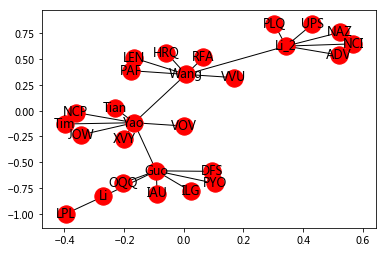

In [58]:
nx.draw_networkx(social_nework)

In [59]:
sorted(nx.pagerank(social_nework).items(), key=lambda x: x[1], reverse=True)

[('Yao', 0.14018616244938112),
 ('Guo', 0.12625952492883674),
 ('Wang', 0.12354105488402628),
 ('Li_2', 0.11100157862592008),
 ('Li', 0.04009295437632798),
 ('LPL', 0.022595018111845305),
 ('UPS', 0.021279981196290158),
 ('ADV', 0.021279981196290158),
 ('PLQ', 0.021279981196290158),
 ('NCI', 0.021279981196290158),
 ('NAZ', 0.021279981196290158),
 ('OQQ', 0.02088716348418851),
 ('PYO', 0.02088716348418851),
 ('DFS', 0.02088716348418851),
 ('ILG', 0.02088716348418851),
 ('IAU', 0.02088716348418851),
 ('LEN', 0.020557581368083087),
 ('RFA', 0.020557581368083087),
 ('PAF', 0.020557581368083087),
 ('HRQ', 0.020557581368083087),
 ('VVU', 0.020557581368083087),
 ('Tian', 0.020450012730142263),
 ('Tim', 0.020450012730142263),
 ('XVY', 0.020450012730142263),
 ('VOV', 0.020450012730142263),
 ('NCP', 0.020450012730142263),
 ('JOW', 0.020450012730142263)]